In [2]:
from src.graph_utils import *
from src import pge
from src import abe
from src import ace
import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [40]:
from deap import base, creator, tools, algorithms

In [45]:
import random
from scipy.optimize import minimize


In [39]:
from qiskit.circuit.library import Diagonal
from qiskit import QuantumCircuit, Aer, execute
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.result import QuasiDistribution

In [38]:
from qiskit_algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals

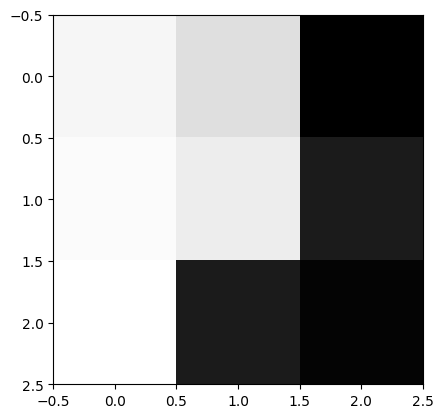

In [48]:
height,width = 3,3

image = np.array([
       [0.92,  0.87, 0.39],
       [0.93,  0.90, 0.45],
       [0.94,  0.45, 0.40]
       ])
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

In [49]:
def image_to_grid_graph(gray_img, sigma=0.5):
  # Convert image to grayscale
  # gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])
  h, w = gray_img.shape
  # Initialize graph nodes and edges
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  # Compute node potentials and edge weights
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x-1,y]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x,y-1]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))
      # print('weight',weight)
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_edges = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in nx_elist]
  return nodes, edges, nx_elist, normalized_edges, normalized_nx_elist

pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)



pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist

(array([[0.92],
        [0.87],
        [0.39],
        [0.93],
        [0.9 ],
        [0.45],
        [0.94],
        [0.45],
        [0.4 ]]),
 [(1, 0, 0.00498752080731768),
  (2, 1, 0.3692211794525717),
  (3, 0, 0.00019998000133325533),
  (4, 1, 0.0017983809715627075),
  (4, 3, 0.0017983809715627075),
  (5, 2, 0.007174142096186609),
  (5, 4, 0.3330231891415256),
  (6, 3, 0.00019998000133325533),
  (7, 4, 0.3330231891415256),
  (7, 6, 0.3813403524973774),
  (8, 5, 0.00498752080731768),
  (8, 7, 0.00498752080731768)],
 [((0, 1), (0, 0), 0.0),
  ((0, 2), (0, 1), 0.37),
  ((1, 0), (0, 0), 0.0),
  ((1, 1), (0, 1), 0.0),
  ((1, 1), (1, 0), 0.0),
  ((1, 2), (0, 2), 0.01),
  ((1, 2), (1, 1), 0.33),
  ((2, 0), (1, 0), 0.0),
  ((2, 1), (1, 1), 0.33),
  ((2, 1), (2, 0), 0.38),
  ((2, 2), (1, 2), 0.0),
  ((2, 2), (2, 1), 0.0)],
 [(1, 0, 0.97),
  (2, 1, -0.94),
  (3, 0, 1.0),
  (4, 1, 0.99),
  (4, 3, 0.99),
  (5, 2, 0.96),
  (5, 4, -0.75),
  (6, 3, 1.0),
  (7, 4, -0.75),
  (7, 6, -1.0),
  (8, 5

In [50]:
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)

In [51]:
G.nodes()

NodeView(((0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)))

Pos: {(0, 0): (0, 0), (0, 1): (1, 0), (0, 2): (2, 0), (1, 0): (0, -1), (1, 1): (1, -1), (1, 2): (2, -1), (2, 0): (0, -2), (2, 1): (1, -2), (2, 2): (2, -2)}
{((0, 0), (1, 0)): 1.0, ((0, 0), (0, 1)): 1.0, ((0, 1), (1, 1)): 1.0, ((0, 1), (0, 2)): -0.94, ((0, 2), (1, 2)): 0.95, ((1, 0), (2, 0)): 1.0, ((1, 0), (1, 1)): 1.0, ((1, 1), (2, 1)): -0.73, ((1, 1), (1, 2)): -0.73, ((1, 2), (2, 2)): 1.0, ((2, 0), (2, 1)): -0.99, ((2, 1), (2, 2)): 1.0}


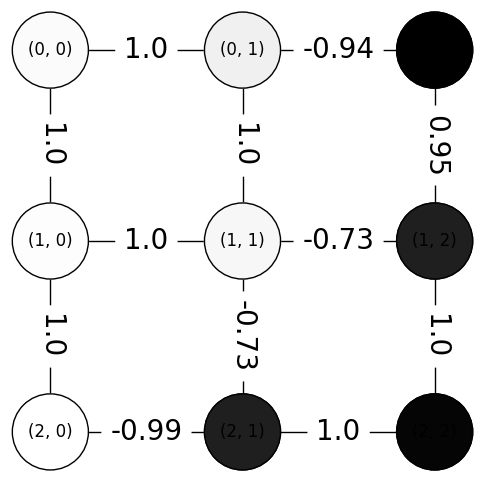

In [52]:
def draw(G):
  plt.figure(figsize=(6,6))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  print("Pos:",pos)
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=3000,
                  cmap=plt.cm.Greys,
                  alpha=1,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=3000,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  print(edge_labels)
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                              edge_labels=edge_labels,
                              font_size=20)
  plt.axis('off')
#   plt.savefig("2x2_graph.jpg", dpi=600, bbox_inches='tight', pad_inches=0)
draw(G)

#### Brute Force Solver

In [53]:
def bf_solver(G):
  n = G.number_of_nodes()
  w = nx.adjacency_matrix(G).todense()
  # print('weights matrix =',w)
  best_cost_brute = 100000
  for b in range(2**(n-1)):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
      for j in range(n):
        cost = cost + w[i,j]*x[i]*(1-x[j])
    if cost < best_cost_brute:
      best_cost_brute = cost
      xbest_brute = x
  return xbest_brute, best_cost_brute

#### Minimum Eigen Solver (Classical)

In [54]:
def me2_solver(G):
  n = G.number_of_nodes()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  result = exact.solve(qp)
  # return result.x, result.fval
  ee = NumPyMinimumEigensolver()
  result = ee.compute_minimum_eigenvalue(qubitOp)
  x = max_cut.sample_most_likely(result.eigenstate)
  return x, qp.objective.evaluate(x)

#### Qiskit QAOA Solver

In [55]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    cost = 0
    for i in range(len(x)):
        for j in range(len(x)):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    return cost

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

In [56]:
def qaoa_solver(G, reps=1):
  n = G.number_of_nodes()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  # print(qp.prettyprint())
  qubitOp, offset = qp.to_ising()
  sampler = Sampler()
  algorithm_globals.random_seed = 123
  optimizer = COBYLA()
  qaoa = QAOA(sampler, optimizer, reps=reps)
  result = qaoa.compute_minimum_eigenvalue(qubitOp)
  x = sample_most_likely(result.eigenstate)
  return x, objective_value(x, w)

#### Parametric Gate Encoding (PGE)

In [57]:
def R(theta):
  if abs(theta) > 2*np.pi or abs(theta) < 0:
    theta = abs(theta) - (np.floor(abs(theta)/(2*np.pi))*(2*np.pi))
  return 0 if 0 <= theta < np.pi else 1

def cost_fn(params, hermitian_observable):
  global optimization_iteration_count
  optimization_iteration_count += 1
  N = int(np.log2(len(params)))
  circuit_psi = QuantumCircuit(N)
  for i in range(N):
    circuit_psi.h(i)
  diagonal_elements = [np.exp(1j * np.pi * R(param)) for param in params]
  diag_gate = Diagonal(diagonal_elements)
  circuit_psi.append(diag_gate, range(N))
  op_observable = SparsePauliOp.from_operator(hermitian_observable)
  cost = Estimator().run(circuit_psi, op_observable).result().values[0]
  print(f'@ Iteration {optimization_iteration_count} Cost :',cost)
  return cost

def decode(optimal_params):
  return [R(param) for param in optimal_params]

In [58]:
def new_nisq_ga_solver2(G, population_size=50, crossover_probability=0.7, mutation_probability=0.2, number_of_generations=50):
    n = G.number_of_nodes()
    w = nx.adjacency_matrix(G).todense()
    D_G = np.diag(list(dict(G.degree()).values()))
    A_G = w
    L_G = D_G - A_G
    n_padding = (2**int(np.ceil(np.log2(n))) - n)
    L_G = np.pad(L_G, [(0, n_padding), (0, n_padding)], mode='constant')
    H = L_G

    # Genetic Algorithm Setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0.5, 2*np.pi)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluate function with padding
    def evaluate_with_padding(individual):
        padded_individual = individual + [0] * n_padding  # Append constant values for padding
        return cost_fn(padded_individual, H),

    toolbox.register("evaluate", evaluate_with_padding)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Run Genetic Algorithm
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, verbose=False)

    # Extract the best solution
    best_ind = tools.selBest(population, 1)[0]
    optimal_params = best_ind + [0] * n_padding  # Append constant values for padding
    expectation_value = best_ind.fitness.values[0]

    # Decode and calculate cut value
    x = np.real(decode(optimal_params))
    x = x[:n]
    cut_value = objective_value(x, w)

    return x, expectation_value, cut_value


In [59]:
def new_nisq_algo_solver(G, optimizer_method = 'Genetic', initial_params_seed=123):
  global optimization_iteration_count
  optimization_iteration_count = 0
  if optimizer_method == 'Genetic':
    x, expectation_value, cut_value = new_nisq_ga_solver2(G,
                                                         population_size = 50,
                                                         crossover_probability = 0.7,
                                                         mutation_probability = 0.2,
                                                         number_of_generations = 50)
    success_flag = True
  else:
    n = G.number_of_nodes()
    w = nx.adjacency_matrix(G).todense()
    D_G = np.diag(list(dict(G.degree()).values()))
    A_G = w
    L_G = D_G - A_G
    n_padding = (2**int(np.ceil(np.log2(n)))-n)
    L_G = np.pad(L_G, [(0, n_padding), (0, n_padding) ], mode='constant')
    H = L_G
    # if initial_params is None:
    np.random.seed(seed=initial_params_seed)
    initial_params = np.random.uniform(low=0.5, high=2*np.pi , size=(n+n_padding))
    # optimizers_scipy = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
    # print(optimizer_method)
    options = {}
    result = minimize(
        fun=cost_fn,
        x0=initial_params,  # Initial guess for the parameters
        args=H,    # Additional arguments passed to evaluate_cost
        method=optimizer_method,
        options=options)
    
    optimal_params, expectation_value = result.x, result.fun
    x = np.real(decode(optimal_params))
    x = x[:n]
    cut_value = objective_value(x, w)
    success_flag = result.success
  return success_flag, x, expectation_value, cut_value

In [60]:
success_flag, x, expectation_value, cut_value = new_nisq_algo_solver(G, optimizer_method = 'Powell')
success_flag, x, expectation_value, cut_value

@ Iteration 1 Cost : 1.497499999999999
@ Iteration 2 Cost : 1.497499999999999
@ Iteration 3 Cost : 1.497499999999999
@ Iteration 4 Cost : 1.497499999999999
@ Iteration 5 Cost : 1.497499999999999
@ Iteration 6 Cost : 0.7624999999999992
@ Iteration 7 Cost : 0.7624999999999992
@ Iteration 8 Cost : 0.7624999999999992
@ Iteration 9 Cost : 0.7624999999999992
@ Iteration 10 Cost : 0.7624999999999992
@ Iteration 11 Cost : 0.7624999999999992
@ Iteration 12 Cost : 0.7624999999999992
@ Iteration 13 Cost : 0.7624999999999992
@ Iteration 14 Cost : 0.7624999999999992
@ Iteration 15 Cost : 0.7624999999999992
@ Iteration 16 Cost : 0.7624999999999992
@ Iteration 17 Cost : 0.7624999999999992
@ Iteration 18 Cost : 1.2349999999999992
@ Iteration 19 Cost : 1.2349999999999992
@ Iteration 20 Cost : 0.7624999999999992
@ Iteration 21 Cost : 0.7624999999999992
@ Iteration 22 Cost : 0.7624999999999992
@ Iteration 23 Cost : 0.7624999999999992
@ Iteration 24 Cost : 0.7624999999999992
@ Iteration 25 Cost : 0.762499

(True,
 array([1, 1, 0, 1, 1, 0, 1, 0, 1]),
 0.5825000000000001,
 -1.3899999999999997)